# Surviving the Titanic: Predicting Passenger Survival using Neural Network in TensorFlow

- Author: Asad Raza Virk

- Date: 2024-11-25

- Contact: www.x.com/virkat

This notebook is a submission for the Titanic: Machine Learning from Disaster competition on Kaggle. The goal of this competition is to predict which passengers survived the Titanic shipwreck. 

The notebook is divided into the following sections:

1. Introduction
2. Data Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Conclusion

Let's get started!

## 1. Introduction

The Titanic dataset contains information about passengers on the Titanic, including whether they survived or not. The goal of this competition is to predict whether a passenger survived the disaster based on the given features.

In this notebook, we will explore the data, preprocess it, engineer new features, develop a machine learning model, and evaluate its performance.

Let's start by loading the data and exploring its contents.

In [68]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [69]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Data Exploration

In this section, we will load the data and explore its contents to understand the features and their distributions.

In [70]:
# load data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/gender_submission.csv')

In [71]:
# check train data
df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
# check test data
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [73]:
# check submission data
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [74]:
# check data types in df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 3. Data Preprocessing

In this section, we will preprocess the data by handling missing values, encoding categorical variables, and splitting the data into training and testing sets.

In [75]:
# print perncentage of the missing values in df_train and also sort them
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
missing_values = missing_values / len(df_train) * 100
missing_values



Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

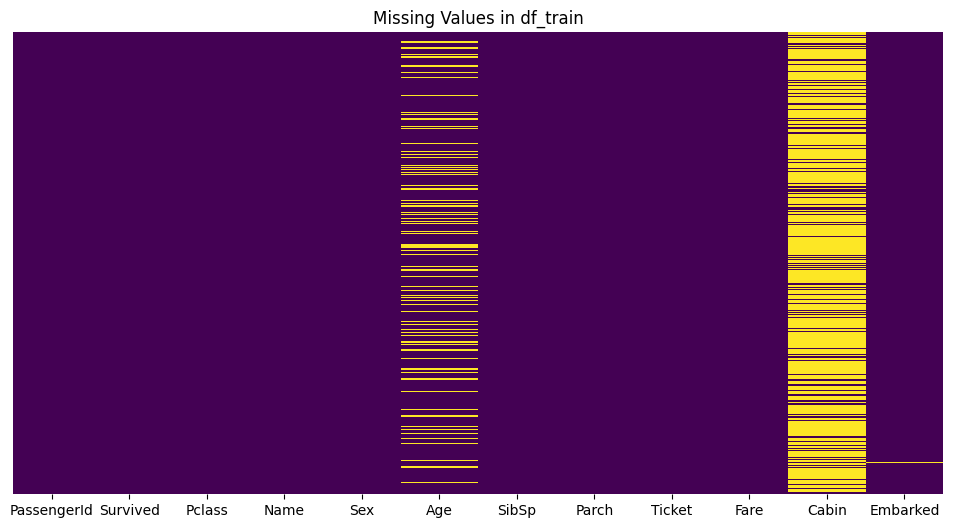

In [76]:
# plot missing values
plt.figure(figsize=(12,6))
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values in df_train')
plt.show()

To impute the missing values in the Age, Embarked, and Cabin columns in the Titanic dataset, the appropriate methods would be:

- `Age`: Use a regression model to predict missing values, as it is numerical.
- `Embarked`: Use the mode (most frequent value), as it is categorical with a small number of unique values.
- `Cabin`: Since the Cabin column is more complex (high cardinality and sparse), we can impute missing values with "Unknown" or another appropriate placeholder.

In [77]:
# impute the missing values in Age column
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Separate features for Age imputation
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Preprocess and encode categorical columns
categorical_features = ['Pclass', 'Sex', 'Embarked']
numeric_features = ['Fare', 'SibSp', 'Parch']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Age Imputation
train_data = df_train[df_train['Age'].notna()]
predict_data = df_train[df_train['Age'].isna()]

X_train = train_data[features]
y_train = train_data['Age']
X_pred = predict_data[features]

# Create pipeline for regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict missing ages
df_train.loc[df_train['Age'].isna(), 'Age'] = pipeline.predict(X_pred)



In [78]:
# impute the missing values in Embarked column with the most frequent value
df_train['Embarked'].value_counts()

df_train['Embarked'].fillna('S', inplace=True)

# impute the missing values in Cabin column with 'U' for unknown
df_train['Cabin'].fillna('U', inplace=True)


In [79]:
# check the missing values in df_train
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64